## Run 'sudo jetson_clocks' before running this notebook¶

# Import Required Packages

In [1]:
import tensorrt as trt
import mnist_reader
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from helper import *

# GPU Info

In [2]:
from jtop import jtop

with jtop() as jetson:
    board = jetson.board
    NV_Power_Mode = jetson.nvpmodel

In [3]:
print('{:<20} {:<20}'.format('NV Power Mode:',NV_Power_Mode.name))
print('\n') 
print('Board info:')
print('==============================================================================================') 
for k, v in board.info.items():
    print ("{:<20} {:<20}".format(k+':',v))  
    
print('\n')     
print('Hardware:')
print('==============================================================================================') 
for k, v in board.hardware.items():
    print ("{:<20} {:<20}".format(k+':',v))

print('\n') 
print('Libraries:')
print('==============================================================================================') 
for k, v in board.libraries.items():
    print ("{:<20} {:<20}".format(k+':',v))


NV Power Mode:       MAXN                


Board info:
machine:             NVIDIA Jetson Nano (Developer Kit Version)
jetpack:             4.6                 
L4T:                 32.6.1              


Hardware:
TYPE:                Nano (Developer Kit Version)
CODENAME:            porg                
SOC:                 tegra210            
CHIP_ID:             33                  
BOARDIDS:            3448                
MODULE:              P3448-0000          
BOARD:               P3449-0000          
CUDA_ARCH_BIN:       5.3                 
SERIAL_NUMBER:       0421119002548       


Libraries:
CUDA:                10.2.300            
cuDNN:               8.2.1.32            
TensorRT:            8.0.1.6             
VisionWorks:         1.6.0.501           
OpenCV:              4.1.1               
OpenCV-Cuda:         NO                  
VPI:                 ii libnvvpi1 1.1.12 arm64 NVIDIA Vision Programming Interface library
Vulkan:              1.2.70              


# Loading the Fashion MNIST Dataset

In [4]:
fashion_mnist_labels = ["T-shirt/top", 
                            "Trouser",
                            "Pullover",
                            "Dress",
                            "Coat",
                            "Sandal", 
                            "Shirt",
                            "Sneaker",
                            "Bag",
                            "Ankle boot"]

In [5]:
x_test,y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

In [6]:
x_test = x_test/255

test_size = x_test.shape[0]

INPUT_SHAPE = [28,28,1] 

x_test = x_test.reshape([-1]+INPUT_SHAPE)


print(f'Test size: {test_size}')
print(f'Test data shape: {x_test.shape}')


Test size: 10000
Test data shape: (10000, 28, 28, 1)


# Loading and Running the TensorRT Engine

In [7]:
fp32_engine = load_engine("fp32_model.trt")

Reading engine from file fp32_model.trt


In [8]:
num_pics = x_test.shape[0]
prediction = np.zeros((num_pics), dtype = np.uint8)


for i in tqdm(range(num_pics)):
    score = infer(fp32_engine, np.expand_dims(x_test[i],axis=0))
    prediction[i] = score.argmax()
        
print('accuracy:', np.mean(prediction == y_test))

100%|██████████| 10000/10000 [01:48<00:00, 92.33it/s]

accuracy: 0.9186


# Timing Operations

In [9]:
img = np.expand_dims(x_test[0],axis=0)


In [10]:
%%timeit -o -r 1000 -n 1 -q

score = infer(fp32_engine, img)    

<TimeitResult : 9.71 ms ± 124 µs per loop (mean ± std. dev. of 1000 runs, 1 loop each)>

In [11]:
result = _
print('FPS:',1/np.mean(result.all_runs))

FPS: 103.00956462658537


# Plotting the Result

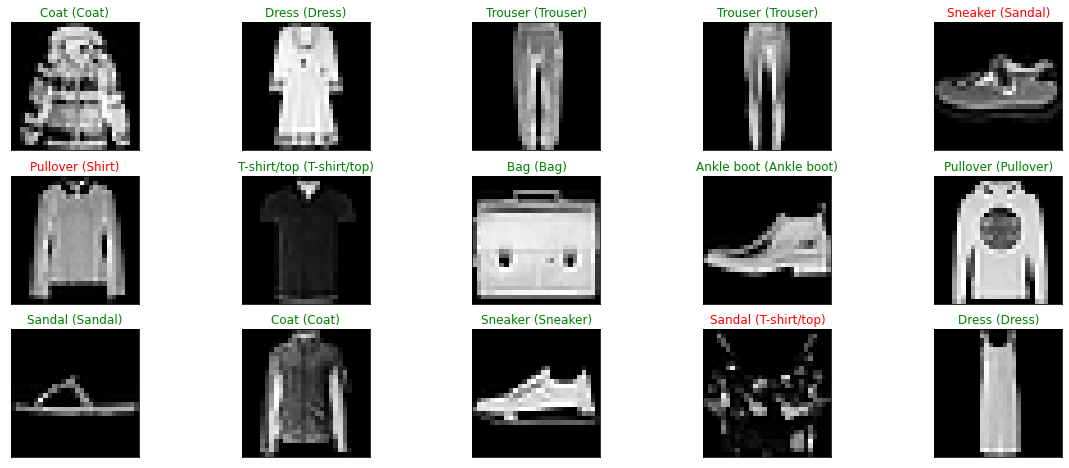

In [12]:
figure = plt.figure(figsize=(20,8))

for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
   
    ax.imshow(x_test[index].reshape(28,28), cmap='gray')
    predict_index = prediction[index]
    true_index = y_test[index]
   
    ax.set_title("{} ({})".format(fashion_mnist_labels[predict_index], 
                fashion_mnist_labels[true_index]),
                color=("green" if predict_index == true_index else "red"))